In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from validation import compute_permutation_importance

# keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

2023-08-10 18:10:56.429114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Rafael's case
df_good1 = pd.read_csv('data/likely_matches_plane.csv')

df_good = df_good1.query("prob >= 0.95 and separation <= 0.2")
df_bad = pd.read_csv('data/unlikely_matches_plane.csv')

In [3]:
# Vinay's case
df_good_v = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")

def create_bad_dataset(df, feature_names, shape):
    df_bad = df.sample(n=shape[0])

    # Features without corresponding error and over_error
    no_error_features = ['separation', 'bp_rp', 'bp_g', 'g_rp']

    # Randomly select values for features without corresponding error and over_error
    for feature in no_error_features:
        random_values = df[feature].sample(len(df), replace=True).reset_index(drop=True)
        df_bad[feature] = random_values

    # Features with corresponding error and over_error
    error_features = [feature for feature in feature_names if feature not in no_error_features]

    for feature in error_features:
        random_rows = df.sample(len(df), replace=True).reset_index(drop=True)
        df_bad[feature] = random_rows[feature]
        df_bad[feature + '_error'] = random_rows[feature + '_error']
        df_bad[feature + '_over_error'] = random_rows[feature + '_over_error']

    return df_bad

feature_names = [
    'separation', 
    'phot_g_mean_flux', 
    'phot_bp_mean_flux', 
    'phot_rp_mean_flux', 
    'bp_rp', 
    'bp_g', 
    'g_rp',
    'parallax'
]

# Apply the function to create the bad dataset
df_bad_v = create_bad_dataset(df_bad, feature_names, df_good_v.shape)

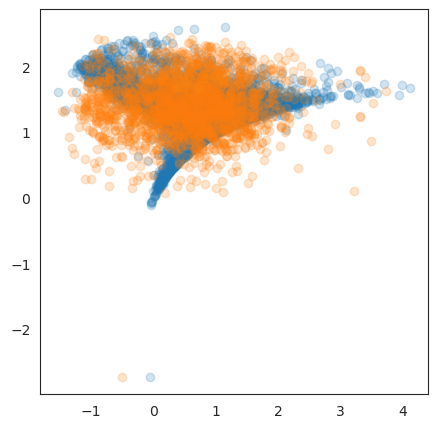

In [21]:
plt.scatter(df_good_v['bp_g'],df_good_v['g_rp'],alpha=0.2,)
plt.scatter(df_bad_v['bp_g'],df_bad_v['g_rp'],alpha=0.2)

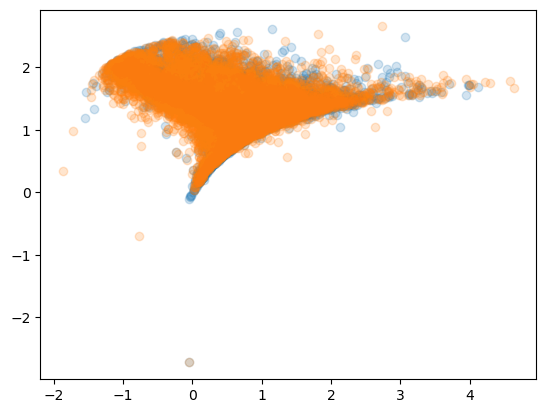

In [15]:
plt.scatter(df_good['bp_g'],df_good['g_rp'],alpha=0.2,)
plt.scatter(df_bad['bp_g'],df_bad['g_rp'],alpha=0.2)

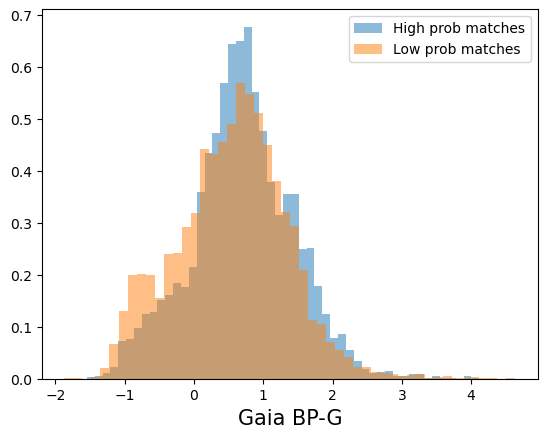

In [16]:
plt.hist(df_good['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

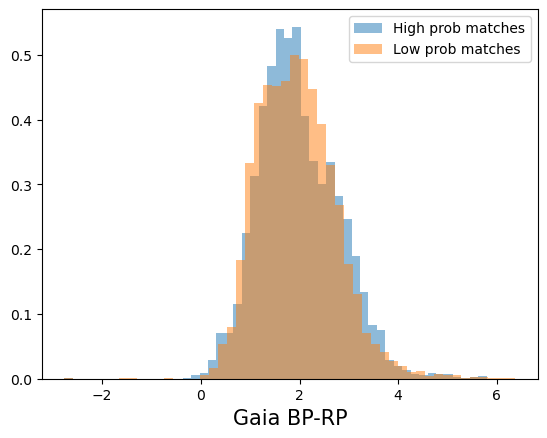

In [17]:
plt.hist(df_good['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

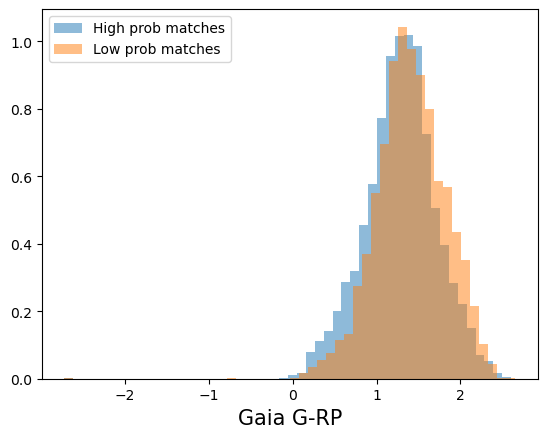

In [18]:
plt.hist(df_good['g_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['g_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G-RP',size=15)
plt.legend()
plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

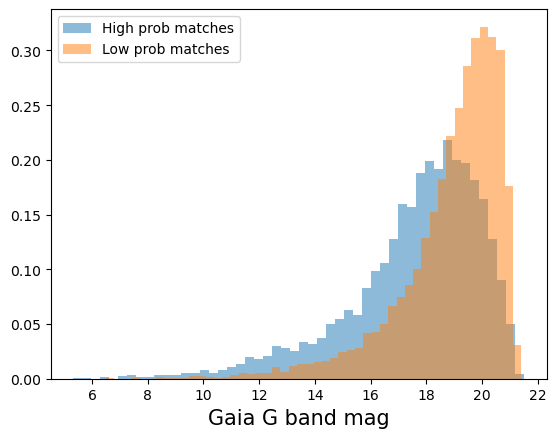

In [19]:
plt.hist(df_good['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

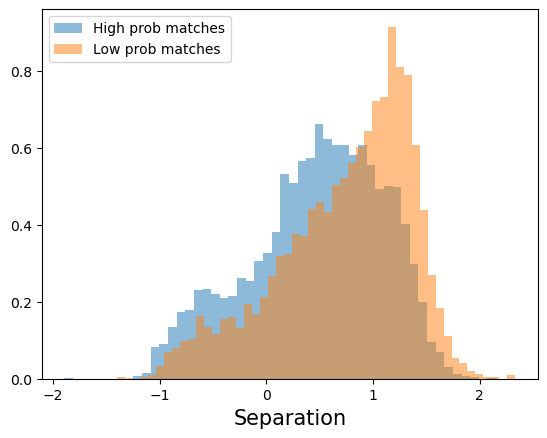

In [20]:
plt.hist(np.log10(100./df_good['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(100./df_bad['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Separation',size=15)
#plt.xscale('log')
plt.legend()
plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

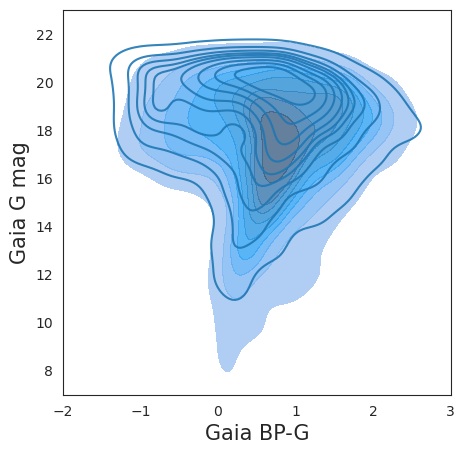

In [22]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good.bp_g, y=df_good.phot_g_mean_mag, label = 'High prob matches',fill=True,alpha=0.8)
sns.kdeplot(x=df_bad.bp_g, y=df_bad.phot_g_mean_mag, label = 'Low prob matches',fill=False,alpha=0.9)
plt.xlim(-2,3)
plt.ylim(7,23)
plt.xlabel('Gaia BP-G',size=15)
plt.ylabel('Gaia G mag',size=15)
plt.savefig('figures/contour.pdf',dpi=300)

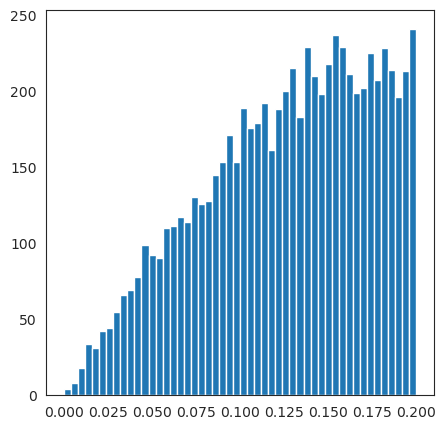

In [49]:
plt.hist(df_good['separation'],bins=50)
plt.show()

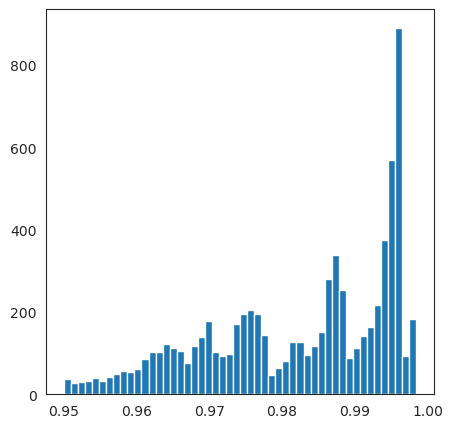

In [44]:
plt.hist(df_good['prob'],bins=50)
plt.show()

---
#### Preprocessing

In [24]:
feature_names = [
    'separation', 
    'phot_g_mean_flux', 
    'phot_g_mean_flux_error', 
    'phot_g_mean_flux_over_error', 
    'phot_bp_mean_flux', 
    'phot_bp_mean_flux_error', 
    'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_flux', 
    'phot_rp_mean_flux_error', 
    'phot_rp_mean_flux_over_error', 
    'bp_rp', 
    'bp_g', 
    'g_rp',
    'parallax', 
    'parallax_over_error'
]

# List of features to skip for the log transformation
skip_log_features = ['separation', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error']

## Random Feature
# Add random values to the DataFrame
# r = np.random.RandomState(42)
# df_good['random_feature'] = r.rand(len(df_good))
# df_bad['random_feature'] = r.rand(len(df_bad))

# # Add the random feature name to the feature names list
# feature_names.append('random_feature')
# skip_log_features.append('random_feature')

def transform_features(df):
    transformed_features = [
        np.log10(df[feature].values) if feature not in skip_log_features else df[feature].values
        for feature in feature_names
    ]
    return np.array(transformed_features).T

def preprocess(df_good, df_bad):
    # Transform features
    X_good = transform_features(df_good)
    X_bad = transform_features(df_bad)

    # Concatenate X and create Y labels
    X = np.concatenate((X_good, X_bad), axis=0)
    Y = np.concatenate((np.ones(len(X_good)), np.zeros(len(X_bad))), axis=0)

    return X, Y

def handle_missing_values(X_train, X_test):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imp_mean.fit_transform(X_train)
    X_test = imp_mean.transform(X_test)
    return X_train, X_test

def standardize(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [25]:
# Preprocess the data
X, Y = preprocess(df_good_v, df_bad_v)

# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

# Handle missing values
X_train, X_test = handle_missing_values(X_train, X_test)

# Standardize
X_train, X_test = standardize(X_train, X_test)

In [26]:
print(X_train.shape, X_test.shape)

(8069, 15) (3459, 15)


In [27]:
from collections import Counter

def class_proportions(y):
    counts = Counter(y)
    total = len(y)
    proportions = {key: value / total for key, value in counts.items()}
    return proportions

train_proportions = class_proportions(Y_train)
test_proportions = class_proportions(Y_test)

print("Training proportions:", train_proportions)
print("Test proportions:", test_proportions)

Training proportions: {0.0: 0.5041516916594374, 1.0: 0.49584830834056265}
Test proportions: {0.0: 0.49031511997687194, 1.0: 0.5096848800231281}


In [28]:
num_samples = X.shape[0]
nan_count_per_feature = np.isnan(X).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature separation: 0.00%
Percentage of NaN values in feature phot_g_mean_flux: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_error: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_over_error: 0.00%
Percentage of NaN values in feature phot_bp_mean_flux: 25.30%
Percentage of NaN values in feature phot_bp_mean_flux_error: 25.30%
Percentage of NaN values in feature phot_bp_mean_flux_over_error: 25.30%
Percentage of NaN values in feature phot_rp_mean_flux: 25.43%
Percentage of NaN values in feature phot_rp_mean_flux_error: 25.43%
Percentage of NaN values in feature phot_rp_mean_flux_over_error: 25.43%
Percentage of NaN values in feature bp_rp: 25.26%
Percentage of NaN values in feature bp_g: 25.34%
Percentage of NaN values in feature g_rp: 25.49%
Percentage of NaN values in feature parallax: 13.97%
Percentage of NaN values in feature parallax_over_error: 13.97%


---
#### Baseline Models

In [16]:
# Model Building
clf = LogisticRegression(max_iter=10000)  # max_iter may need to be increased depending on data convergence
clf.fit(X_train, Y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_prob))

#feature_importances = clf.coef_[0]
#for i, imp in enumerate(feature_importances):
#    print(f"{feature_names[i]}: Coefficient = {imp:.4f}")

Accuracy: 0.8169690501600854
Precision: 0.7065015479876161
Recall: 0.6727594339622641
F1 Score: 0.6892177589852008
AUC-ROC: 0.902346115399033


In [29]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

Accuracy: 0.9921942758022549
Precision: 0.9876404494382023
Recall: 0.9971639251276234
F1 Score: 0.9923793395427604
AUC-ROC: 0.9996737510568392


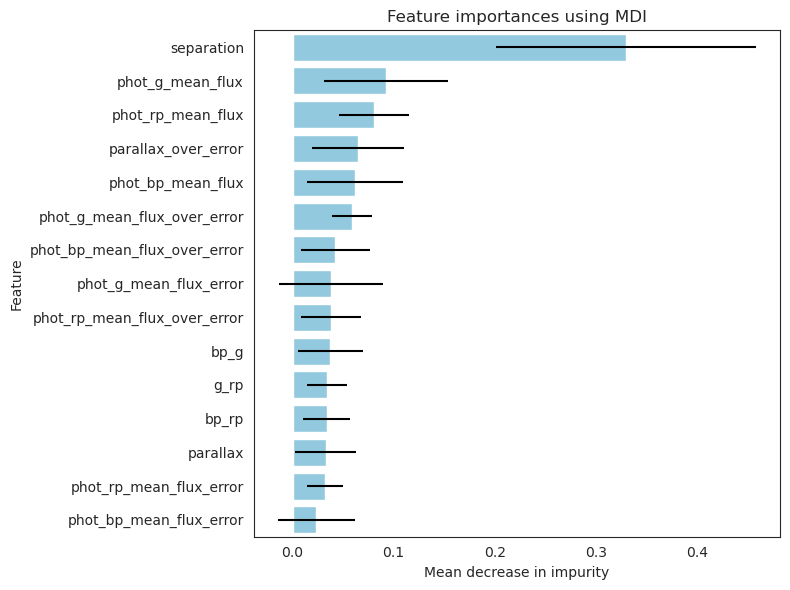

In [30]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a DataFrame to allow Seaborn plotting
importance_df = pd.DataFrame({'Feature': forest_importances.index, 'Importance': forest_importances.values})

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, xerr=std, color='skyblue')
plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity")
plt.tight_layout()
#plt.savefig('figures/importances_rf_without_bands.pdf', dpi=300)

In [52]:
# Model Building
clf_svm = SVC(kernel='linear', probability=True, random_state=42)  # Using 'linear' kernel as a baseline. Probability is True for AUC-ROC.
clf_svm.fit(X_train, Y_train)

# Predictions
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm_prob = clf_svm.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print("Precision:", precision_score(Y_test, y_pred_svm))
print("Recall:", recall_score(Y_test, y_pred_svm))
print("F1 Score:", f1_score(Y_test, y_pred_svm))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_svm_prob))

Accuracy: 0.8047939582991299
Precision: 0.7004477004477004
Recall: 0.7916283348666053
F1 Score: 0.7432519974087671
AUC-ROC: 0.880667949181956


#### NN

In [38]:
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(16,)))
network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
network.add(layers.Dense(1, activation='sigmoid'))

In [39]:
Adagrad = optimizers.Adagrad(learning_rate=0.005)
network.compile(optimizer=Adagrad,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])
#optimizer.lr.set_value(0.02)

In [40]:
history = network.fit(X_train, Y_train, validation_split=0.2, epochs=200, batch_size=256)

Epoch 1/200
45/45 [==============================] - 1s 20ms/step - loss: 0.6740 - binary_accuracy: 0.5909 - val_loss: 0.6242 - val_binary_accuracy: 0.7119
Epoch 2/200
45/45 [==============================] - 1s 20ms/step - loss: 0.6001 - binary_accuracy: 0.7185 - val_loss: 0.5825 - val_binary_accuracy: 0.7309
Epoch 3/200
45/45 [==============================] - 1s 14ms/step - loss: 0.5681 - binary_accuracy: 0.7302 - val_loss: 0.5567 - val_binary_accuracy: 0.7341
Epoch 4/200
45/45 [==============================] - 1s 20ms/step - loss: 0.5453 - binary_accuracy: 0.7395 - val_loss: 0.5364 - val_binary_accuracy: 0.7457
Epoch 5/200
45/45 [==============================] - 1s 18ms/step - loss: 0.5263 - binary_accuracy: 0.7517 - val_loss: 0.5190 - val_binary_accuracy: 0.7496
Epoch 6/200
45/45 [==============================] - 1s 20ms/step - loss: 0.5096 - binary_accuracy: 0.7587 - val_loss: 0.5036 - val_binary_accuracy: 0.7633
Epoch 7/200
45/45 [==============================] - 1s 15ms/ste

In [41]:
network.save('models/model2_1082023_random.h5')

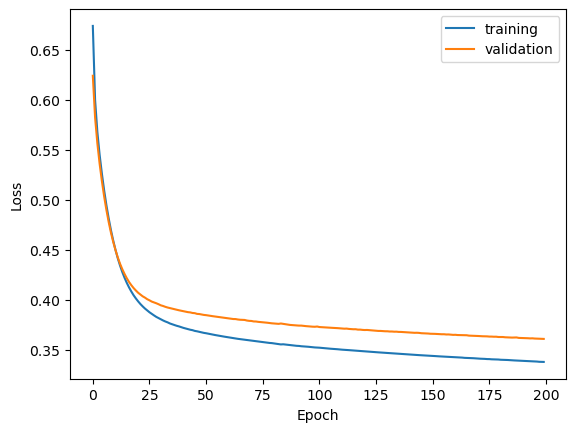

In [42]:
# 200, don't stop until overtfit. 
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('models/loss_nn2_random.pdf')

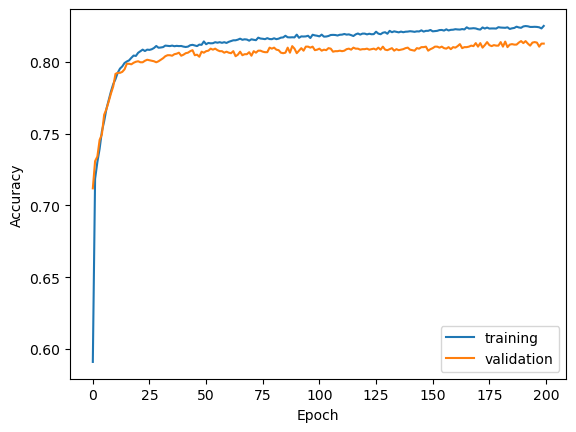

In [43]:
plt.plot(history.history['binary_accuracy'],label='training')
plt.plot(history.history['val_binary_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/acc_nn2_random.pdf')

In [44]:
print('\n# Evaluate on test data')
results = network.evaluate(X_test, Y_test, batch_size=256)
print('test loss, test acc:', results)


# Evaluate on test data
24/24 [==============================] - 0s 9ms/step - loss: 0.3481 - binary_accuracy: 0.8184
test loss, test acc: [0.34806203842163086, 0.8184206485748291]


In [45]:
# Predict probabilities for the test set
y_pred_probs = network.predict(X_test).ravel()

# Convert probabilities to class labels (0 or 1) using a threshold, typically 0.5 for binary classification
y_pred_label = (y_pred_probs > 0.5).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(Y_test, y_pred_label)
recall = recall_score(Y_test, y_pred_label)
f1 = f1_score(Y_test, y_pred_label)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Display metrics
print('\n# Extended Evaluation Metrics')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC:', roc_auc)


191/191 [==============================] - 1s 5ms/step

# Extended Evaluation Metrics
Precision: 0.7313691507798961
Recall: 0.7764489420423183
F1 Score: 0.7532351628737172
AUC: 0.9083531578318179


In [46]:
# Compute permutation importance
importances = compute_permutation_importance(network, X_test, Y_test)

# Display the importances
for i, imp in enumerate(importances):
    print(f"{feature_names[i]}: Importance = {imp:.4f}")

191/191 [==============================] - 1s 4ms/step
separation: Importance = 0.2051
phot_g_mean_flux: Importance = 0.0296
phot_g_mean_flux_error: Importance = 0.0391
phot_g_mean_flux_over_error: Importance = 0.0197
phot_bp_mean_flux: Importance = 0.0126
phot_bp_mean_flux_error: Importance = 0.0128
phot_bp_mean_flux_over_error: Importance = 0.0072
phot_rp_mean_flux: Importance = 0.0046
phot_rp_mean_flux_error: Importance = 0.0062
phot_rp_mean_flux_over_error: Importance = 0.0069
bp_rp: Importance = 0.0064
bp_g: Importance = 0.0177
g_rp: Importance = 0.0105
parallax: Importance = 0.0025
parallax_over_error: Importance = 0.0025
random_feature: Importance = 0.0030


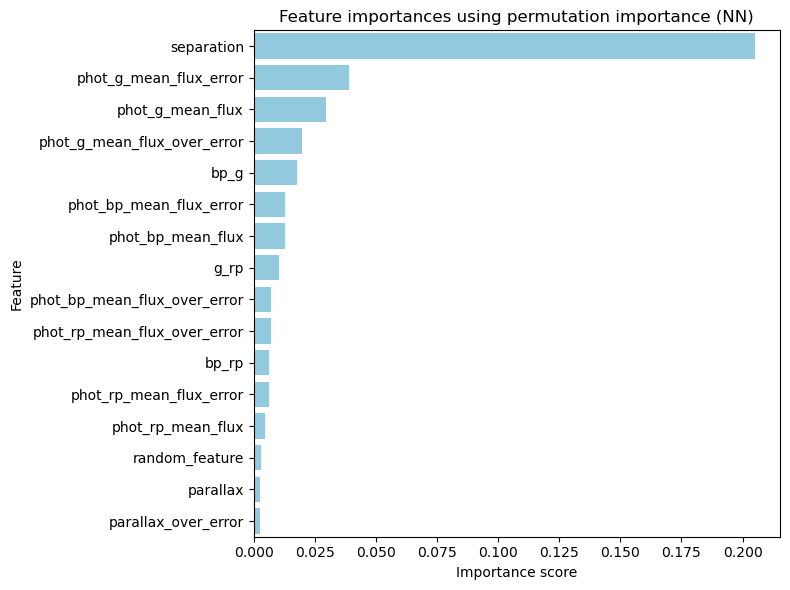

In [47]:
nn_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a DataFrame to allow Seaborn plotting
importance_df = pd.DataFrame({'Feature': nn_importances.index, 'Importance': nn_importances.values})

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title("Feature importances using permutation importance (NN)")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig('figures/importances_nn_random.pdf', dpi=300)